# 1. Comparative False Color Composite Maps of Rikha Samba Glacier (2013 & 2024)
Source: Landsat 8

In [2]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
import ee
import geemap
import matplotlib.pyplot as plt
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry

/Users/anujavenkatachalam/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
# Initialising Earth Engine - enter auth code
ee.Authenticate()
ee.Initialize(project="friendly-plane-476109-q8")

In [5]:
# Setting lat, long from assignment website: https://forms.icimod.org/cryosphere-water-risks/application-form-ml-training/
lat = 28.823742
long = 83.490774

In [6]:
# Create a point object
point = ee.Geometry.Point([long, lat])

In [7]:
# Retrieving the image from Google Earth Landsat 8 collection Top of Atmosphere - b/w oct 2024 to dec 2024
l8_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA').filterBounds(point).filterDate('2024-10-01', '2024-12-31')

In [8]:
# Retrieving the image from Google Earth Landsat 8 collection Top of Atmosphere - b/w oct 2013 to dec 2013
l8_collection_old = ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA').filterBounds(point).filterDate('2013-10-01', '2013-12-31')

In [9]:
# Create base map
map_l8 = geemap.Map(center=[lat, long], zoom=10)

In [10]:
# Defining the bands. For glaciers, we can use B6 or B7. Here, I use B7 to better differentiate b/w rock and debris-covered ice
map_params = {
    'bands': ['B7', 'B5', 'B4'],  # SWIR2, NIR, Red bands map to Red, Green, Blue (RGB)
    'min': 0.05,
    'max': 0.5,
    'gamma': [1.1, 1.0, 1.0]
}

In [11]:
# Extract median from image collection for both periods
fcc_im = l8_collection.median()
fcc_im_old= l8_collection_old.median()

In [12]:
# Checking differences on specific bands
glacier_diff = fcc_im.select('B5').subtract(fcc_im_old.select('B5'))

In [13]:
# Add fcc images with params
map_l8.add_layer(fcc_im_old, map_params, 'Rikha Samba (2013)')
map_l8.add_layer(fcc_im, map_params, 'Rikha Samba (2024)')   

In [14]:
map_l8

Map(center=[28.823742, 83.490774], controls=(WidgetControl(options=['position', 'transparent_bg'], position='t…

In [15]:
# Create base map
map_diff = geemap.Map(center=[lat, long], zoom=10)

In [16]:
diff_params = {
    'min': -0.2,
    'max': 0.2,
    'palette': ['red', 'white', 'green']  # red = decrease in snow/ice, white = no change, green = increase in snow/ice
}

In [17]:
map_diff.add_layer(glacier_diff, diff_params, 'Glacier Change (B5)')


In [18]:
map_diff

Map(center=[28.823742, 83.490774], controls=(WidgetControl(options=['position', 'transparent_bg'], position='t…

# 2. Temperature time-series

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": lat,
	"longitude": long,
	"start_date": "1990-10-04",
	"end_date": "2025-09-30",
	"daily": "temperature_2m_mean",
	"models": "era5_land",
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["temperature_2m_mean"] = daily_temperature_2m_mean

daily_dataframe = pd.DataFrame(data = daily_data)
print("\nDaily data\n", daily_dataframe)

Coordinates: 28.800003051757812°N 83.39999389648438°E
Elevation: 5780.0 m asl
Timezone difference to GMT+0: 0s

Daily data
                            date  temperature_2m_mean
0     1990-10-04 00:00:00+00:00            -6.372500
1     1990-10-05 00:00:00+00:00            -5.587083
2     1990-10-06 00:00:00+00:00            -5.016251
3     1990-10-07 00:00:00+00:00            -5.341249
4     1990-10-08 00:00:00+00:00            -6.651667
...                         ...                  ...
12776 2025-09-26 00:00:00+00:00            -1.320417
12777 2025-09-27 00:00:00+00:00            -1.628750
12778 2025-09-28 00:00:00+00:00            -1.114167
12779 2025-09-29 00:00:00+00:00            -1.612083
12780 2025-09-30 00:00:00+00:00            -2.770417

[12781 rows x 2 columns]


In [27]:
daily_dataframe["date"]= pd.to_datetime(daily_dataframe["date"]).dt.date

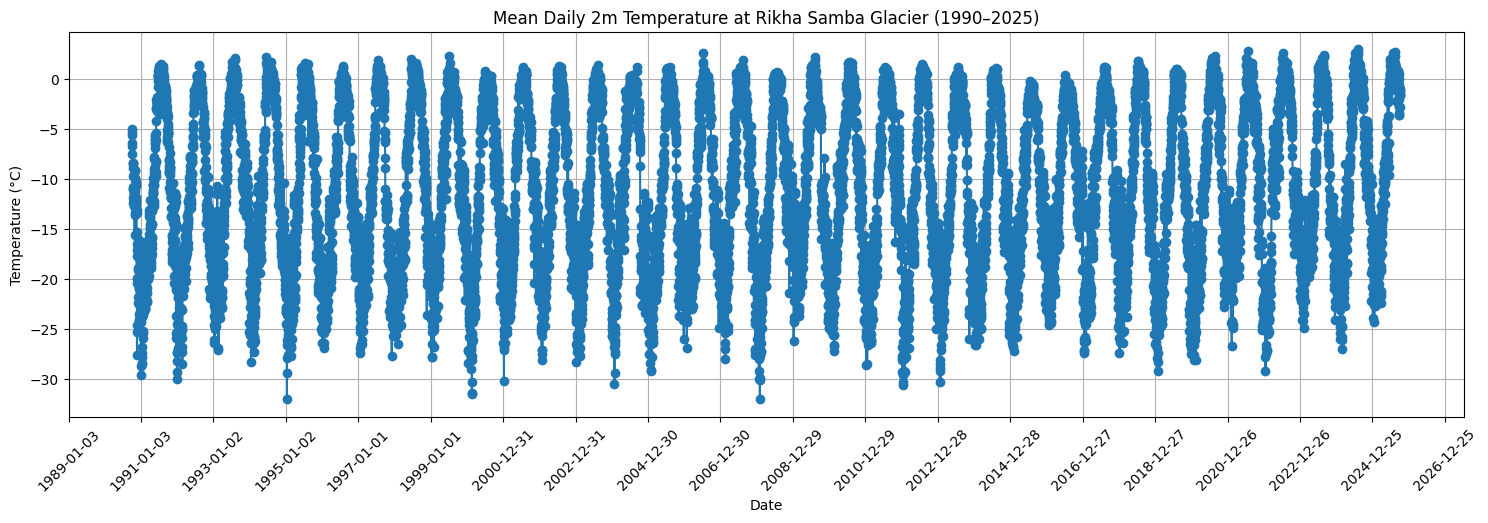

In [ ]:


plt.figure(figsize=(18,5))
plt.plot(daily_dataframe['date'], daily_dataframe['temperature_2m_mean'], marker='o', linestyle='-')
plt.title('Mean Daily 2m Temperature at Rikha Samba Glacier (1990–2025)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
xmin, xmax = plt.xlim()
plt.xticks(range(int(xmin), int(xmax)+1, 2*365), rotation=45)  
plt.grid(True)
plt.show()


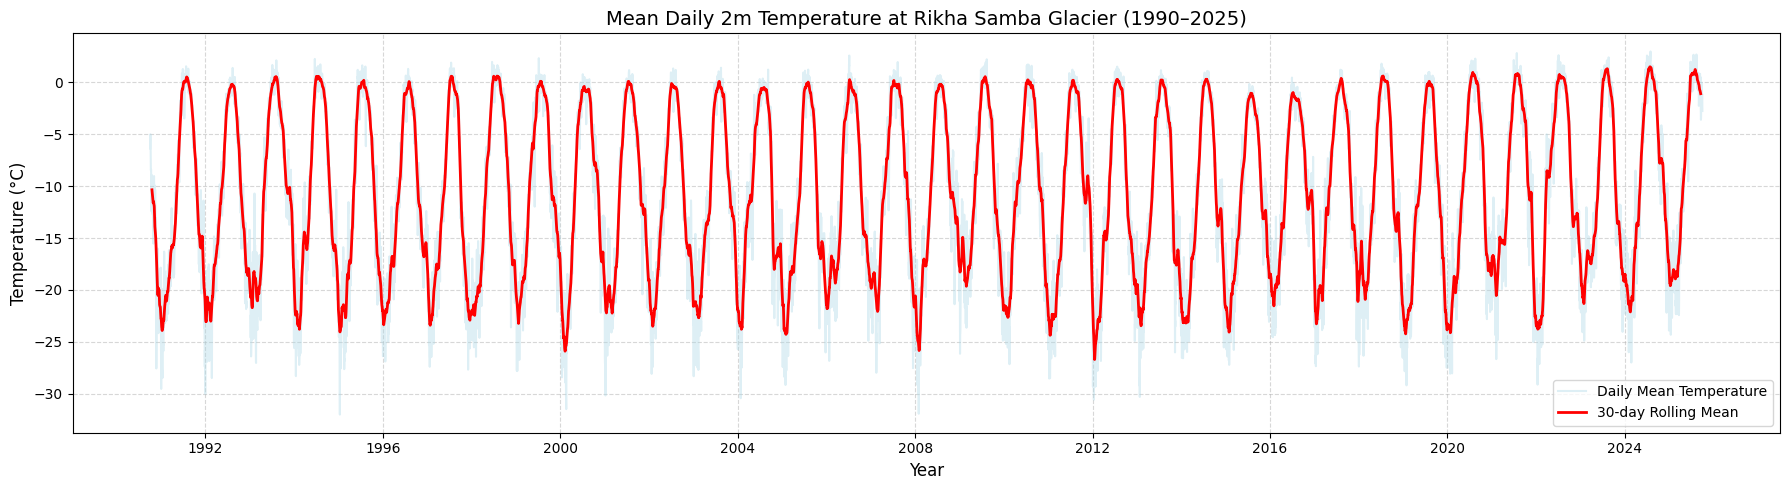

In [ ]:
daily_dataframe['date'] = pd.to_datetime(daily_dataframe['date'])

# 30 day rolling avg 
daily_dataframe['temp_rolling_30d'] = daily_dataframe['temperature_2m_mean'].rolling(window=30, center=True).mean()

fig, ax = plt.subplots(figsize=(18,5))

ax.plot(daily_dataframe['date'], daily_dataframe['temperature_2m_mean'], color='lightblue', alpha=0.4, label='Daily Mean Temperature')
ax.plot(daily_dataframe['date'], daily_dataframe['temp_rolling_30d'], color='red', linewidth=2, label='30-day Rolling Mean')


# Labels, title, legend
ax.set_title('Mean Daily 2m Temperature at Rikha Samba Glacier (1990–2025)', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


The End!